<a href="https://colab.research.google.com/github/MMol04/CorVsPar/blob/main/Modelos/CorianderVsParsleyEfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CODIGO CORIANDER VS PARSLEY EFFICIENTNET**

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from google.colab import drive
import os

In [ ]:
# Accessing My Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Constants
BATCH_SIZE = 16
EPOCHS = 50
IMG_SIZE = 96
NUM_CLASSES = 1

In [ ]:
# Paths
train_path = "/content/drive/MyDrive/BD_cor_par/train/"
test_path = "/content/drive/MyDrive/BD_cor_par/test/"
MODEL_PATH_ROOT = "/content/drive/MyDrive/BD_cor_par/efficientEfficiency/"
MODELTF_PATH = MODEL_PATH_ROOT + 'modelFold3.h5'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 1615 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 404 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['coriander', 'parsley']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def evalModelByFold(num_classes, train_ds, valid_fold, val_grl, nFold=0):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    base_model.trainable = True

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    #model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    metrics = ["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

    checkpointer = ModelCheckpoint(MODEL_PATH_ROOT + f"modelFold{nFold}.h5", verbose=1, save_best_only=True)

    results = model.fit(train_ds, validation_data=valid_fold, epochs=EPOCHS, callbacks=[checkpointer])
    np.save(MODEL_PATH_ROOT + f'model_history_fold{nFold}.npy', results.history)

    loss, accuracy, recall, precision = model.evaluate(valid_fold, batch_size=BATCH_SIZE, verbose=0)
    lossVAL, accuracyVAL, recallVAL, precisionVAL = model.evaluate(val_grl, batch_size=BATCH_SIZE, verbose=0)
    return loss, accuracy, recall, precision, results, model, lossVAL, accuracyVAL, recallVAL, precisionVAL

In [ ]:
def run_Experiment_TrainModel(train_ds, val_ds):
    kfold = KFold(n_splits=10)
    best_model = None
    best_val_score = float('-inf')
    best_results = None
    scoreloss=[]
    scoresaccuracy = []
    scoresrecall = []
    scoresprecision = []
    scoresf1 =[]

    scorelossV=[]
    scoresaccuracyV = []
    scoresrecallV = []
    scoresprecisionV = []
    scoresf1V =[]

    train_images, train_labels = zip(*[(x, y) for x, y in train_ds])
    val_images, val_labels = zip(*[(x, y) for x, y in val_ds])

    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)
    val_images = np.concatenate(val_images)
    val_labels = np.concatenate(val_labels)

    for k, (train, test) in enumerate(kfold.split(train_images)):
        trainX, trainY = train_images[train], train_labels[train]
        testX, testY = train_images[test], train_labels[test]

        train_fold_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY)).batch(BATCH_SIZE)
        val_fold_ds = tf.data.Dataset.from_tensor_slices((testX, testY)).batch(BATCH_SIZE)

        loss, accuracy, recall, precision, results, model, lossVAL, accuracyVAL, recallVAL, precisionVAL = evalModelByFold(NUM_CLASSES, train_fold_ds, val_fold_ds, val_ds, k)

        f1score = (2*precision*recall)/(precision+recall)
        scoreloss.append(loss)
        scoresaccuracy.append(accuracy)
        scoresrecall.append(recall)
        scoresprecision.append(precision)
        scoresf1.append(f1score)

        f1scoreV = (2*precisionVAL*recallVAL)/(precisionVAL+recallVAL)
        scorelossV.append(lossVAL)
        scoresaccuracyV.append(accuracyVAL)
        scoresrecallV.append(recallVAL)
        scoresprecisionV.append(precisionVAL)
        scoresf1V.append(f1scoreV)

    data_scores = list(zip(scoreloss, scoresaccuracy, scoresrecall, scoresprecision, scoresf1, scorelossV, scoresaccuracyV, scoresrecallV, scoresprecisionV, scoresf1V)) #para el csv
    np.savetxt(MODEL_PATH_ROOT + 'MetricasEN.csv', data_scores, delimiter=',')
    return results

In [ ]:
#run_Experiment_TrainModel(train_ds, val_ds)

In [ ]:
# Obtener el mejor modelo
results=run_Experiment_TrainModel(train_ds, val_ds)



16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/50
91/91 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.8692 - recall: 0.8513 - precision: 0.8851
Epoch 1: val_loss improved from inf to 3809.83838, saving model to /content/drive/MyDrive/BD_cor_par/efficientEfficiency/modelFold0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 47s 76ms/step - loss: 0.5023 - accuracy: 0.8692 - recall: 0.8513 - precision: 0.8851 - val_loss: 3809.8384 - val_accuracy: 0.5123 - val_recall: 1.0000 - val_precision: 0.5123
Epoch 2/50
90/91 [============================>.] - ETA: 0s - loss: 0.1260 - accuracy: 0.9514 - recall: 0.9503 - precision: 0.9530
Epoch 2: val_loss improved from 3809.83838 to 50.25605, saving model to /content/drive/MyDrive/BD_cor_par/efficientEfficiency/modelFold0.h5
91/91 [==============================] - 5s 55ms/step - loss: 0.1255 - accuracy: 0.9511 - recall: 0.9495 - precision: 0.9534 - val_loss: 50.2561 - val_accuracy: 0.5062 - val_recall: 0.9759 - val_precision: 0.5094
Epoch 3/50
90/91 [============================>.] - ETA: 0s - loss: 0.0583 - accuracy: 0.9785 - recall: 0.9807 - precision: 0.9766
Epoch 3: val_loss improved from 50.25605 to 0.49734, saving model to /content/drive/MyDrive/BD_cor_par/efficientEfficiency/modelFold0.h5
91/91 [=========================

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Hacer predicciones con el mejor modelo
best_model2 = tf.keras.models.load_model('/content/drive/MyDrive/BD_cor_par/efficientEfficiency/modelFold9.h5')

pred = best_model2.predict(val_ds)
pred[pred <= 0.5] = 0.
pred[pred > 0.5] = 1.
pred_digits = pred
#pred
#pred_digits = pred.argmax(axis=1)

26/26 [==============================] - 2s 7ms/step


In [ ]:
# Obtener las etiquetas verdaderas
labelsTrue = []
for images, labels in val_ds.take(-1):  # solo tomar el primer elemento del conjunto de datos
    numpy_images= images.numpy()
    numpy_labels = labels.numpy()
    print(numpy_labels)
    for lbl in labels.numpy():
        labelsTrue.append(lbl)

[1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1]
[0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0]
[1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0]
[1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0]
[1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1]
[0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0]
[1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1]
[1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 0]
[1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1]
[0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0]
[1 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0]
[0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0]
[1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1]
[1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0]
[0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0]
[1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1]
[1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1]
[1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0]
[0 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1]
[0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0]
[1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0]
[0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0]
[0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0]
[1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0]
[0 1 1 0]


In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_true=labelsTrue, y_pred=pred_digits)
print("Matriz de Confusión:")
print(cm)

# Obtener otras métricas
accuracy = accuracy_score(labelsTrue, pred_digits) * 100
print("Accuracy: " + str(accuracy) + '%')
print("Reporte de Clasificación:")
print(classification_report(labelsTrue, pred_digits, target_names=['coriander', 'parsley']))

Matriz de Confusión:
[[192   8]
 [  0 204]]
Accuracy: 98.01980198019803%
Reporte de Clasificación:
              precision    recall  f1-score   support

   coriander       1.00      0.96      0.98       200
     parsley       0.96      1.00      0.98       204

    accuracy                           0.98       404
   macro avg       0.98      0.98      0.98       404
weighted avg       0.98      0.98      0.98       404



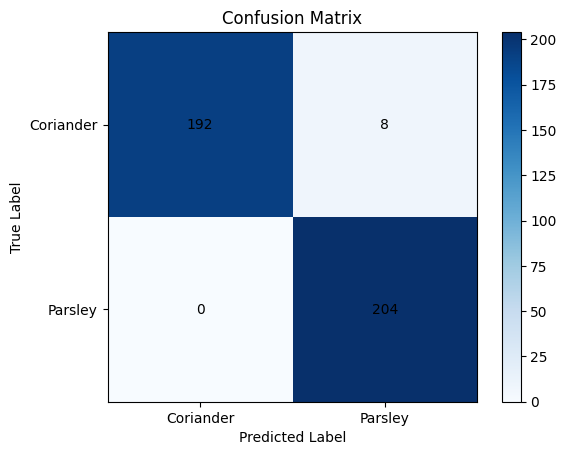

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt


# Define class labels
class_labels = ['Coriander', 'Parsley']

# Generate the plot
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Fill the plot with values
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#best_model.predict(val_ds)

{'loss': [0.6572681069374084, 0.24624942243099213, 0.09296227991580963, 0.0384121909737587, 0.047937363386154175, 0.5296710729598999, 1.4085253477096558, 0.41984468698501587, 0.29310041666030884, 0.23567616939544678, 0.17647238075733185, 0.14605215191841125, 0.10205396264791489, 0.0879666656255722, 0.07694883644580841, 0.41786959767341614, 0.28743183612823486, 0.14096808433532715, 0.08960282802581787, 0.06334423273801804, 0.048689160495996475, 0.03696219250559807, 0.02998310886323452, 0.040426675230264664, 0.024098020046949387, 0.017032088711857796, 0.008091754280030727, 0.007891370914876461, 0.016712328419089317, 0.012586275115609169, 0.04840356111526489, 0.08419989049434662, 0.01701688952744007, 0.004618936683982611, 0.05008262023329735, 0.030342070385813713, 0.007186309900134802, 0.004386160522699356, 0.0009013658855110407, 0.0003772338095586747, 0.0004464138182811439, 0.0001655604428378865, 0.00015083150356076658, 0.0001939166832016781, 0.0875299721956253, 0.16315586864948273, 0.08

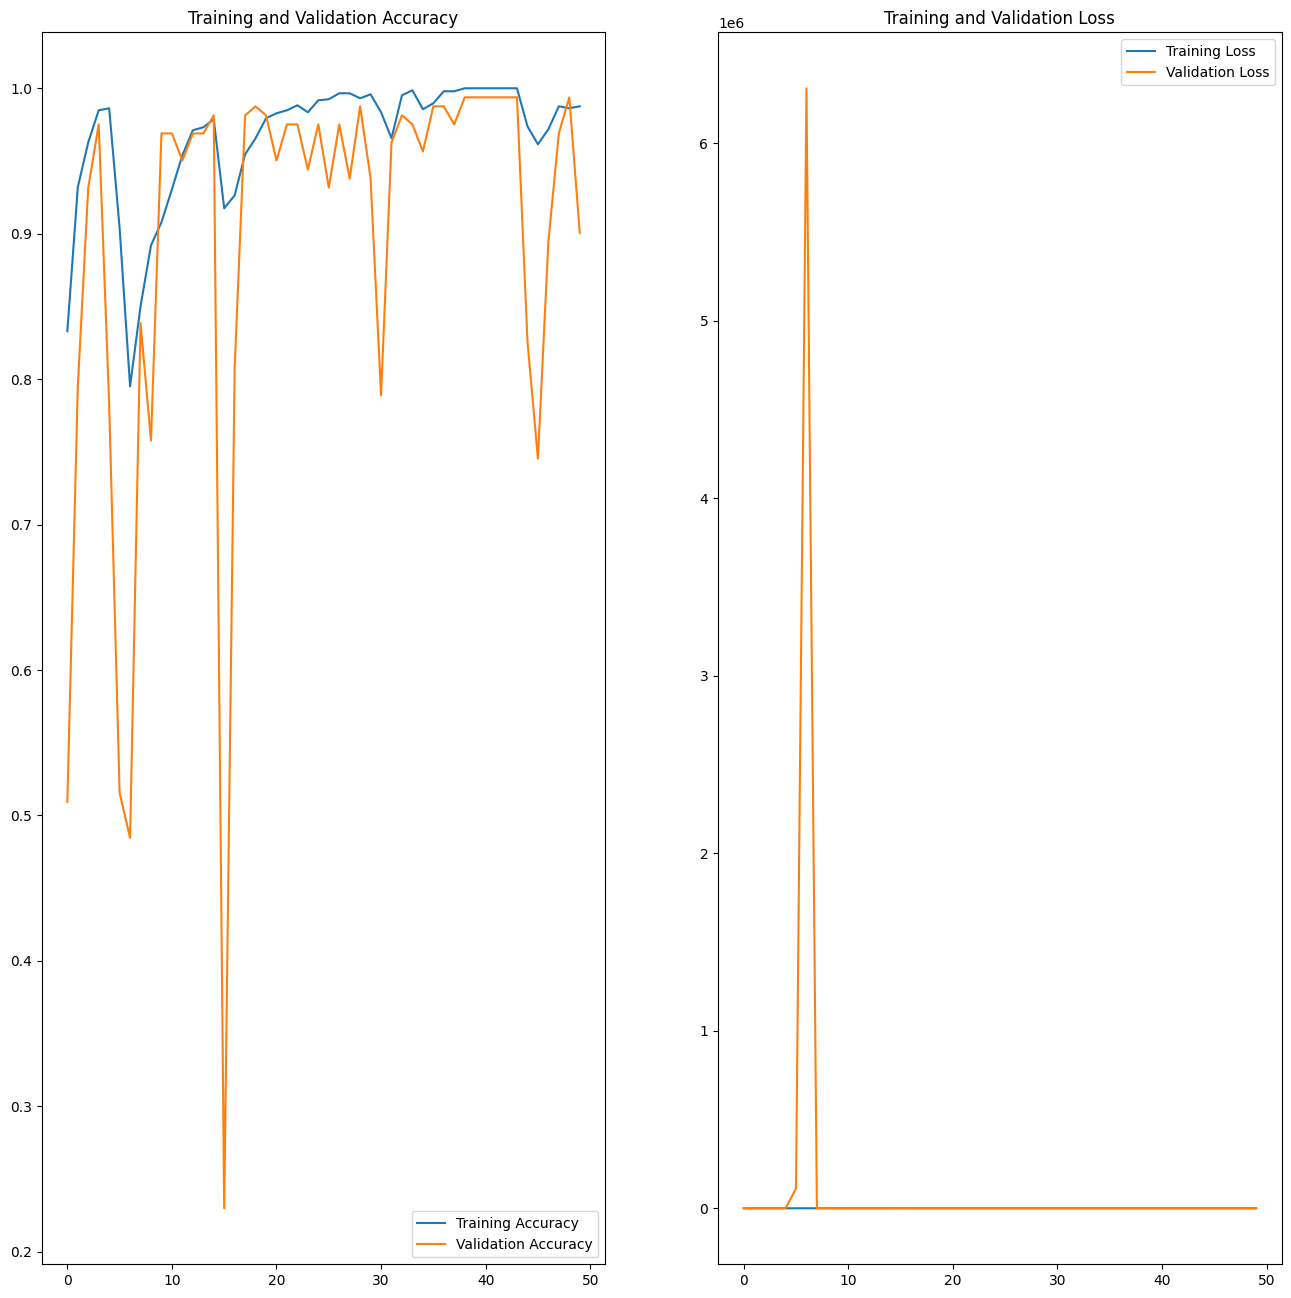

In [ ]:
history = results.history
print(history)

epochs = EPOCHS
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
fig.savefig(MODEL_PATH_ROOT+'1.training fig.png', dpi=400)
plt.show()

In [ ]:
import pandas as pd
model_report = classification_report(labelsTrue, pred_digits, target_names=activity_labels,output_dict=True)
df = pd.DataFrame(model_report).transpose()

df

NameError: name 'activity_labels' is not defined

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
#predicting the data
y_pred_cnb = best_model.predict(val_ds)
#y_prob_pred_cnb = model.predict_proba(val_ds)

#roc auc score
roc_auc_score(labelsTrue, y_pred_cnb, multi_class='ovo', average='weighted')

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(1):
    fpr[i], tpr[i], thresh[i] = roc_curve(labelsTrue, pred)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Target vs No-Target')
plt.title('Binary classification ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [ ]:
json_config = best_model.to_json()
print(json_config)
with open(MODEL_PATH_ROOT+"/model_classification.json", "w") as json_file:
    json_file.write(json_config)